# TRADING BOT USING LSTM

#### The aim of this project is to implement techniques that will improve the performance of the LSTM algorithm to enable it make predictions with higher accuracy.

In this notebook we will be looking at data from the stock market for particular technology stocks. Pandas will be used to get stock information, visualize different aspects of it, and finally the future stock prices of Google will be predicted using a Long-Short Term Memory (LSTM) network.

### Importing Libraries

In [3]:
# !pip install -q hvplot
# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader
# !pip install tensorflow
# !pip install -q yfinance
# !pip install finta

# print("COMPLETED")

     |████████████████████████████████| 3.1 MB 4.9 MB/s 
     |████████████████████████████████| 109 kB 5.0 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
     |████████████████████████████████| 462 kB 5.1 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 6.4 MB 11.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
COMPLETED


In [1]:
# Note: Before running this cell, pip install: yfinance, finta, tensorflow, pandas_datareader

import numpy as np                              # for performing mathematical computations on arrays 
import matplotlib.pyplot as plt                 # for visualization purposes 
import pandas as pd                             # for data analysis and manipulation
from datetime import datetime                   # for working with dates as datetime objects
import seaborn as sns                           # for making statistical graphics
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn import preprocessing
from finta import TA
import tensorflow as tf
import keras
from sklearn.metrics import mean_squared_error

# For reading stocks data from yahoo finance
from pandas_datareader.data import DataReader   # extracts data from internet sources into pandas dataframe
import yfinance as yf                           # open-source library for accessing financial data on yahoo finance



# Importing the required keras libraries
from keras.models import Model, Sequential      # linear stack of layers through which the model will be developed
from keras.layers import LSTM                   # Long-Short Term Memory(LSTM) is the RNN to be used in the model
from keras.layers import Dense                  # fully connected layer used to change dimensions of the output vector
from keras.layers import Dropout                # randomly drops neurons while training to prevent overfitting 
from keras.layers import Input, Activation, concatenate
from keras import optimizers
from keras.callbacks import History, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint  



### Data Import

In [4]:
# The downloaded dataset will be stored on google drive as a csv file
# The drive needs to be mounted in order to access the dataset when importing
import os

from google.colab import drive
drive.mount('/content/drive')

active_dir = '/content/drive/My Drive/Colab Notebooks/'
save_files_dir = os.path.join('{}saved_files/'.format(active_dir))    # defining the folder path where exported files will be saved

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']     # AAPL = APPLE, GOOG = Google, MSFT = Microsoft, AMZN = Amazon

# Setting up the time period for the data
end = "2021-04-30" 
start = "2020-01-01" 

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Data Exploration and Analysis

In [6]:
company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.to_csv('{}All_stocks_data.csv'.format(save_files_dir))
df.head()

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.894318,135480400,APPLE
2020-01-03,74.287498,75.144997,74.125000,74.357498,73.175919,146322800,APPLE
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.759010,118387200,APPLE
2020-01-07,74.959999,75.224998,74.370003,74.597504,73.412125,108872000,APPLE
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.593040,132079200,APPLE


In [7]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2021-04-23,3319.100098,3375.000000,3308.500000,3340.879883,3340.879883,3192800,AMAZON
2021-04-26,3348.000000,3428.449951,3330.939941,3409.000000,3409.000000,4880700,AMAZON
2021-04-27,3443.469971,3460.000000,3398.010010,3417.429932,3417.429932,3827100,AMAZON
2021-04-28,3434.800049,3489.879883,3425.000000,3458.500000,3458.500000,4631900,AMAZON
2021-04-29,3505.100098,3514.449951,3435.000000,3471.310059,3471.310059,7682400,AMAZON


**Explanation of what each column represents**

**Company_Name** - represents the company who owns the stock

**Date** - represents the day on which the stock prices were recorded.

**Open** - represents the initial price the stock traded at for that day.

**High** - represents the maximum price the stock traded at during market hours.

**Low** - represents the minimum price the stock traded at during market hours.

**Close** - represent the last price the stock traded at for that day.

**Adj Close** - represents the amended stock closing price after accounting for all applicable corporate actions (e.g stock splits, dividends)

Volume - represents the total number of the stock's securities that were exchanged between buyers and sellers for that day.

In [8]:
# Let's go ahead and play around with the AAPL DataFrame to better understand the data

# Summary Stats
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,334.000000,334.000000,334.000000,334.000000,334.000000,3.340000e+02
mean,103.537186,104.932508,102.081459,103.560659,102.599999,1.448156e+08
std,24.297308,24.350800,23.885696,24.099065,24.130394,6.630628e+07
min,57.020000,57.125000,53.152500,56.092499,55.332169,4.669130e+07
25%,79.442499,80.026249,78.908751,79.566250,78.469210,9.850412e+07
50%,113.497501,115.270000,110.994999,112.915001,111.887341,1.259020e+08
75%,123.757502,125.180000,121.764997,123.660000,122.791702,1.686655e+08
max,143.600006,145.089996,141.369995,143.160004,142.101807,4.265100e+08


In [9]:
# General info
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 2020-01-02 to 2021-04-29
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          334 non-null    float64
 1   High          334 non-null    float64
 2   Low           334 non-null    float64
 3   Close         334 non-null    float64
 4   Adj Close     334 non-null    float64
 5   Volume        334 non-null    int64  
 6   company_name  334 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 20.9+ KB


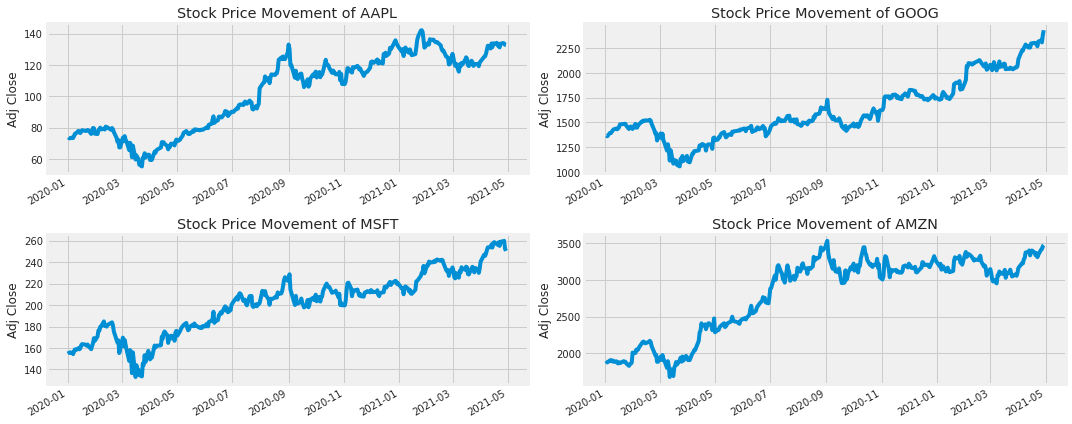

In [10]:
#plotting the growth of the stocks over the four year period.

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Stock Price Movement of {tech_list[i - 1]}")
    
plt.tight_layout()

From the plot we can see that the price per share has risen significantly over time and this is due to the fact that the company's revenue has constantly appreciated each year.

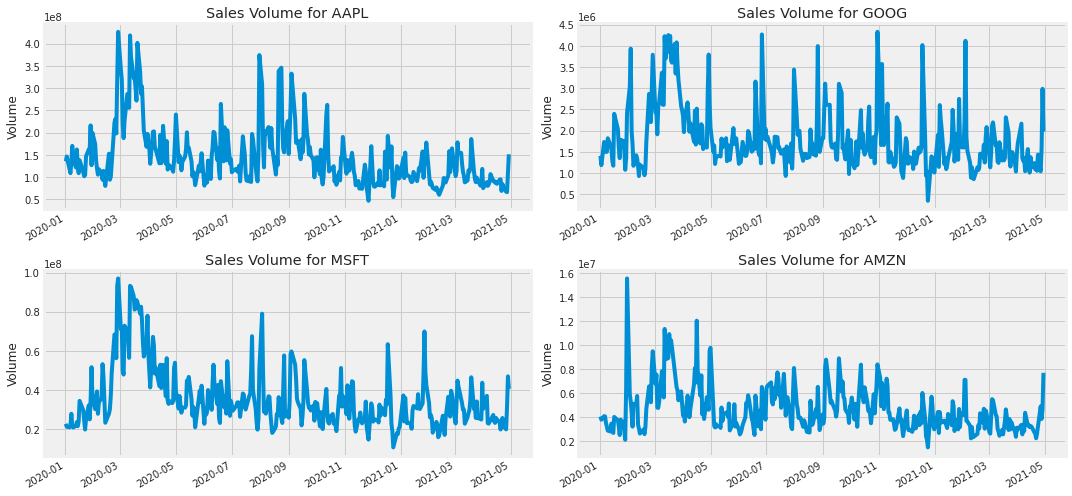

In [11]:
# Now let's plot the total volume of each stock being traded per day

plt.figure(figsize=(15, 7))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")
    
plt.tight_layout()

Now that we've seen the visualizations for the price and volume traded each day, let's calculate the moving average for the stocks.

#### Computing the moving average (MA) for the various stocks
The moving average/rolling mean smooths out the data series of a stock and is used to identify long-term trends.

It is computed by taking the average of the prices for the specified number of days before.

In [12]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()

Now let's go ahead and plot all the additional Moving Averages

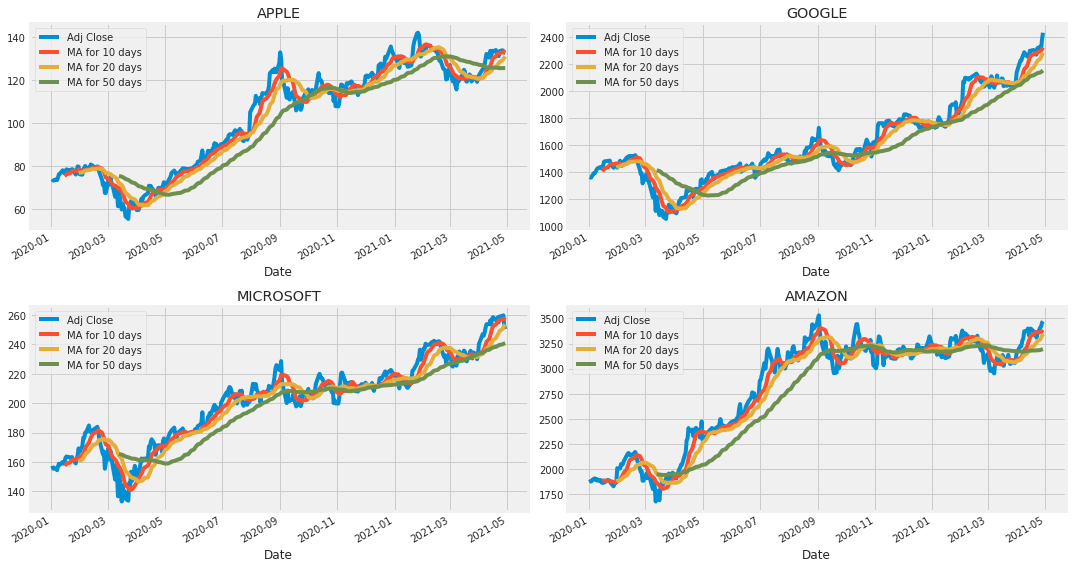

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()

#### Computing the daily return of the stock on average?
Now that we've done some baseline analysis, let's take a closer look at the daily changes of the stock, and not just its absolute value.

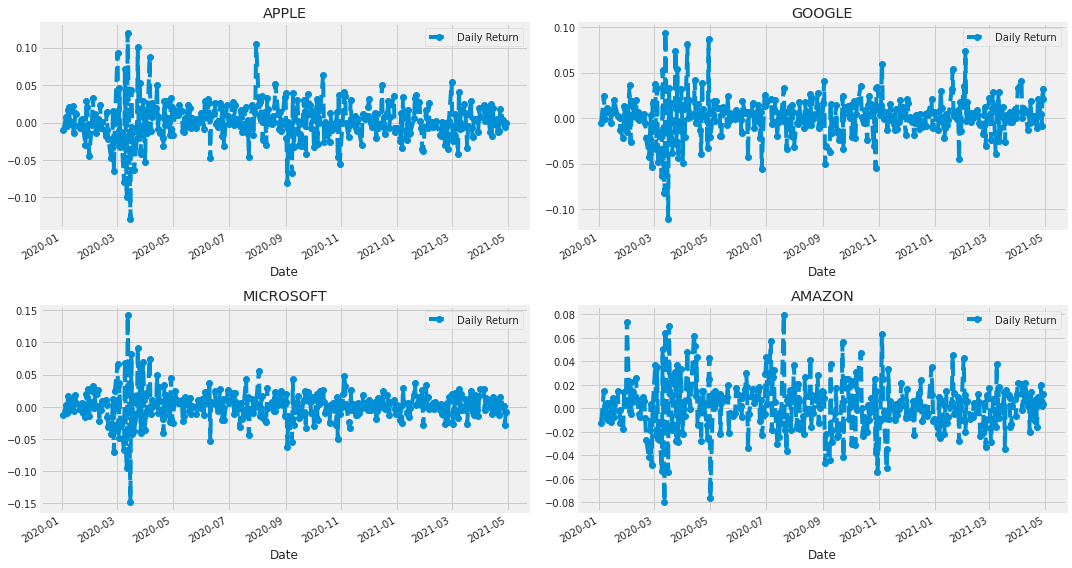

In [14]:
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

GOOG['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

MSFT['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

AMZN['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

Great, now let's get an overall look at the average daily return using a histogram. We'll use seaborn to create both a histogram and kde plot on the same figure.

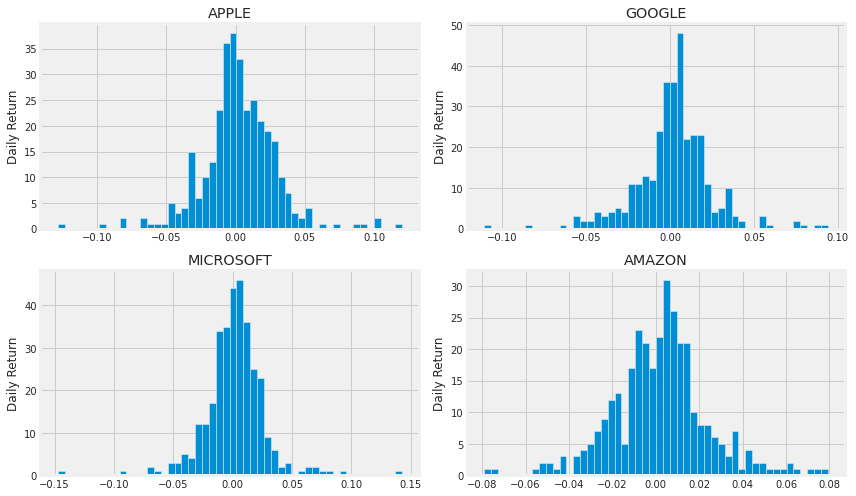

In [15]:
plt.figure(figsize=(12, 7))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.ylabel('Daily Return')
    plt.title(f'{company_name[i - 1]}')
    
plt.tight_layout()

#### Checking for correlation between different stocks closing prices?

Now what if we wanted to analyze the returns of all the stocks in our list? Let's go ahead and build a DataFrame with all the ['Close'] columns for each of the stocks dataframes.

In [16]:
# Grab all the closing prices for the tech stock list into one DataFrame
closing_df = DataReader(tech_list, 'yahoo', start, end)['Adj Close']

# Let's take a quick look
closing_df.head() 

Symbols,AAPL,GOOG,MSFT,AMZN
Date,,,,
2020-01-02,73.894325,1367.369995,157.289902,1898.010010
2020-01-03,73.175926,1360.660034,155.331345,1874.969971
2020-01-06,73.758995,1394.209961,155.732864,1902.880005
2020-01-07,73.412109,1393.339966,154.312897,1906.859985
2020-01-08,74.593040,1404.319946,156.770874,1891.969971


Now that we have all the closing prices, let's go ahead and get the daily return for all the stocks, like we did for the Apple stock.

In [17]:
# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

Symbols,AAPL,GOOG,MSFT,AMZN
Date,,,,
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,-0.009722,-0.004907,-0.012452,-0.012139
2020-01-06,0.007968,0.024657,0.002585,0.014886
2020-01-07,-0.004703,-0.000624,-0.009118,0.002092
2020-01-08,0.016086,0.007880,0.015929,-0.007809


Now we can compare the daily percentage return of two stocks to check how correlated the stocks are. 

First let's see a stock compared to itself.

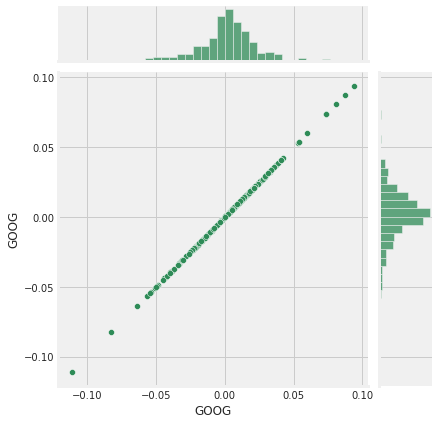

In [18]:
# Comparing Google to itself should show a perfectly linear relationship
sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='seagreen')

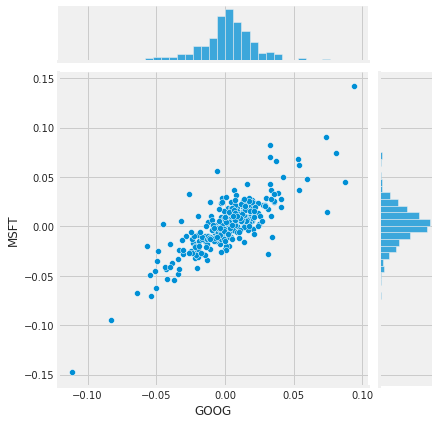

In [19]:
# We'll use joinplot to compare the daily returns of Google and Microsoft
sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter')

So now we can see that if two stocks are perfectly (and positivley) correlated with each other, a linear relationship between its daily return values should occur. 

Let's plot the correlation of the daily returns for every stock

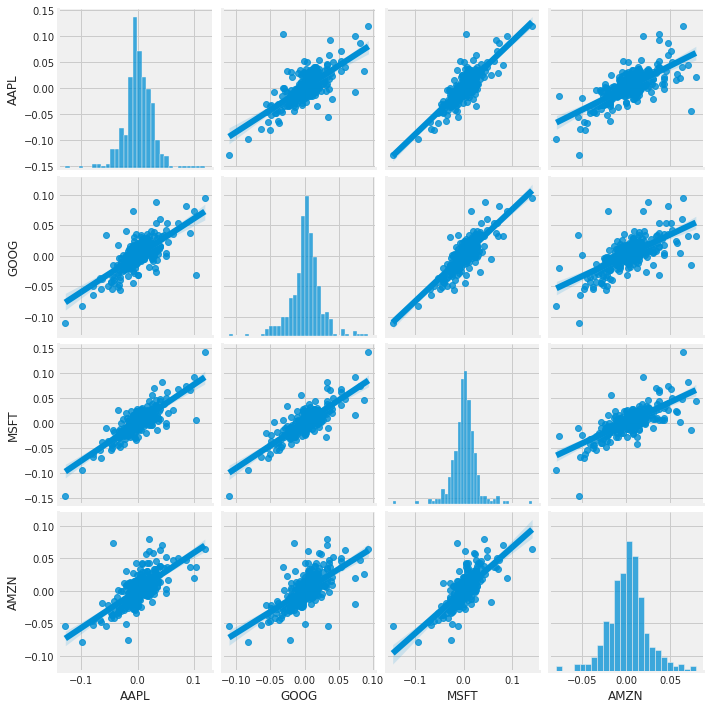

In [20]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis 
# of all the comparisons

sns.pairplot(tech_rets, kind='reg')

Above we can see all the relationships on daily returns between all the stocks. A quick glance shows an interesting correlation between Google and Amazon daily returns.

Finally, we could also do a correlation plot, to get actual numerical values for the correlation between the stocks' daily return values. By comparing the closing prices, we see an interesting positive relationship between Apple and Google with Microsoft. 

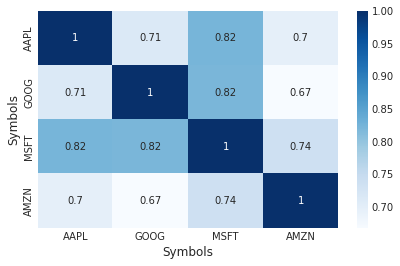

In [21]:
# Let's go ahead and use sebron for a quick correlation plot for the daily returns
sns.heatmap(tech_rets.corr(), annot=True, cmap='Blues')

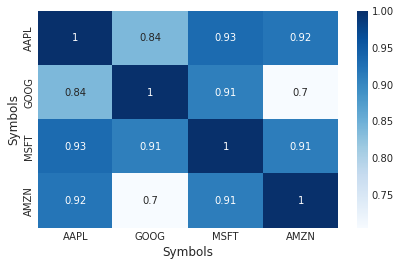

In [22]:
# correlation for the closing prices
sns.heatmap(closing_df.corr(), annot=True, cmap='Blues')

From the correlation plots, we can see that Microsoft and all the other technology companies are positively correlated. Thus from a trading perspective, we can draw an inference that investing in any of the above stocks will yield almost similar returns overtime.

## MODEL DEVELOPMENT

### Data Preprocessing

#### Downloading and importing the data for google stocks from yahoo finance 

In [23]:
if __name__ == "__main__":
    start_date = datetime(2011, 1, 31)
    end_date = datetime(2021, 2, 1)
    #invoke to_csv for df dataframe object from DataReader method in the pandas_datareader library
    df = DataReader("GOOGL", 'yahoo', start_date, end_date)
    df.to_csv('{}google_stocks_data.csv'.format(save_files_dir))

In [24]:
#importing google data from csv file
path = "/content/drive/MyDrive/Colab Notebooks/saved_files/google_stocks_data.csv"
stock_df = pd.read_csv(path)
stock_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2011-01-31,302.537537,298.073059,302.102112,300.480469,5604190.0,300.480469
1,2011-02-01,306.981995,301.856842,302.547546,305.825836,5485109.0,305.825836
2,2011-02-02,307.477478,304.069061,305.805817,306.306305,3517879.0,306.306305
3,2011-02-03,306.031036,303.368378,305.045044,305.380371,2987210.0,305.380371
4,2011-02-04,306.026031,303.608612,305.380371,305.795807,3098498.0,305.795807


In [25]:
#viewing the properties of the google stock data 
stock_df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2518.000000,2518.000000,2518.000000,2518.000000,2.518000e+03,2518.000000
mean,792.495443,777.726295,785.210603,785.376967,2.919051e+06,785.376967
std,400.378942,391.438590,395.646968,396.104837,2.279030e+06,396.104837
min,240.615616,236.746750,237.237244,237.677673,4.656000e+05,237.677673
25%,445.336578,439.817322,443.173187,443.138130,1.488425e+06,443.138130
50%,736.930023,724.205017,733.769989,731.255005,2.097750e+06,731.255005
75%,1112.582520,1084.539978,1097.064972,1099.779999,3.844152e+06,1099.779999
max,1932.079956,1879.410034,1912.739990,1907.949951,2.805931e+07,1907.949951


#### Creating New Dataframe

In [26]:
# This function creates a new data frame with only the adj close price column 

def on_balance_volume_creation(stock_df):
    # Adding the on balance volume to dataframe
    
    new_df = pd.DataFrame({}) # creates an empty dataframe

    new_df = stock_df[['Adj Close']].copy()  # copies the adj close column into the empty dataframe


    new_balance_volume = [0]
    tally = 0

    for i in range(1, len(new_df)):
        if (stock_df['Adj Close'][i] > stock_df['Adj Close'][i - 1]):
            tally += stock_df['Volume'][i]
        elif (stock_df['Adj Close'][i] < stock_df['Adj Close'][i - 1]):
            tally -= stock_df['Volume'][i]
        new_balance_volume.append(tally)

    new_df['On_Balance_Volume'] = new_balance_volume
    minimum = min(new_df['On_Balance_Volume'])

    new_df['On_Balance_Volume'] = new_df['On_Balance_Volume'] - minimum
    new_df['On_Balance_Volume'] = (new_df['On_Balance_Volume']+1).transform(np.log)

    return new_df

In [27]:
# creating a new dataframe for the google stocks
new_df = on_balance_volume_creation(stock_df)
new_df.head()

,Adj Close,On_Balance_Volume
0,300.480469,18.337813
1,305.825836,18.395695
2,306.306305,18.431129
3,305.380371,18.401121
4,305.795807,18.432229


#### Normalization and train_test_splitting

In [28]:
# This function performs data normalization and train_test_split

def train_test_split_preparation(new_df, train_split):
    #Preparation of train test set.
    train_indices = int(new_df.shape[0] * train_split) # multiplies the total number of rows (2517) by 70% and this will be used as training data

    train_data = new_df[:train_indices]   # 
    test_data = new_df[train_indices:]

    test_data = test_data.reset_index()
    test_data = test_data.drop(columns = ['index'])

    normaliser = preprocessing.MinMaxScaler()
    train_normalised_data = normaliser.fit_transform(train_data)

    test_normalised_data = normaliser.transform(test_data)

    X_train = np.array([train_normalised_data[:,0:][i : i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])

    y_train = np.array([train_normalised_data[:,0][i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])
    y_train = np.expand_dims(y_train, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    next_day_close_values = np.array([train_data['Adj Close'][i + history_points].copy() for i in range(len(train_data) - history_points)])
    next_day_close_values = np.expand_dims(next_day_close_values, -1)

    y_normaliser.fit(next_day_close_values)

     
    X_test = np.array([test_normalised_data[:,0:][i  : i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])
    

    y_test = np.array([test_data['Adj Close'][i + history_points].copy() for i in range(len(test_data) - history_points)])
    
    y_test = np.expand_dims(y_test, -1)

    return X_train, y_train, X_test, y_test, y_normaliser

In [29]:
# normalizing and splitting the new training dataframe
train_split = 0.7
    
history_points = 21

X_train, y_train, X_test, y_test, y_reverse_normaliser = train_test_split_preparation(new_df, train_split)
np.shape(X_train), np.shape(y_train)

((1741, 21, 2), (1741, 1))

### INITIAL MODEL

Here we will develop the LSTM network as a sequential model with three lstm layers each having droput regularization to prevent overfitting followed by a fully connected layer before the final output layer.

In [30]:
def lstm_model_seq(X_train, y_train, history_points, n_columns):
    
    # Initializing the RNN
    model = Sequential()                

    # Adding the first LSTM layer and some Dropout regularization 
    model.add(LSTM(256, return_sequences = True, input_shape = (history_points, n_columns)))
    model.add(Dropout(0.2))

    # Adding the second LSTM layer and some Dropout regularization
    model.add(LSTM(128, return_sequences = True))
    model.add(Dropout(0.2))

    # Adding the third LSTM layer and some Dropout regularization
    model.add(LSTM(64, return_sequences = False))
    model.add(Dropout(0.2))

    # Adding a Dense layer before the output layer
    model.add(Dense(21))

    # Adding the output layer
    model.add(Dense(1))


    #Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    model.summary()


    # initialize callbacks
    reduceLR = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-5)

    # induces early stopping if there is no change in validation loss after 20 epochs
    early_stopping = EarlyStopping(monitor='val_loss', patience = 20, verbose=1, mode='min', restore_best_weights= True)

    # saves the model weights after each epoch in which there is an improvement in validation loss
    checkpoint = ModelCheckpoint('LSTM_seqModel.weights.hdf5', monitor='val_loss', verbose=1,save_best_only=True, mode= 'min')

    # training the RNN
    model.fit(x= X_train, y= y_train, epochs = 200, batch_size = 32, shuffle=True, validation_split = 0.1, 
              callbacks= [reduceLR, early_stopping, checkpoint])

    # loading best weights into model
    model.load_weights('LSTM_seqModel.weights.hdf5')

  
    return model

In [31]:
# training the LSTM_seq model
n_columns = 2
model_1 = lstm_model_seq(X_train, y_train, history_points, n_columns)
# saving the model into the specified google drive directory
model_1.save('{}LSTM_seqModel.h5'.format(save_files_dir))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 21, 256)           265216    
                                                                 
 dropout (Dropout)           (None, 21, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 21, 128)           197120    
                                                                 
 dropout_1 (Dropout)         (None, 21, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 21)                1

#### Model Predictions

In [32]:
# This function makes predictions on the test data using the trained model and returns the predicted values.
def model_pred(model_def, X_test):
  y_pred = model_def.predict(X_test)
  y_pred = y_reverse_normaliser.inverse_transform(y_pred)

  return y_pred

In [33]:
# making predictions using the LSTM_seq trained model
y_pred_1 = model_pred(model_1, X_test)
y_train_pred_1 = model_pred(model_1, X_train)

#### Model Evaluation and Plot

In [34]:
# this function plots the graph of the real and predicted prices 

def pred_plot(y_test, y_pred):
  plt.plot(y_test, label='Actual Price')
  plt.plot(y_pred, label='Predicted Price')

  plt.gcf().set_size_inches(16, 8, forward=True)
  plt.title('Plot of real price and predicted price against number of days')
  plt.xlabel('Number of days')
  plt.ylabel('Adjusted Close Price($)')

  plt.legend(['Actual Price', 'Predicted Price'])

  
  plt.show()    

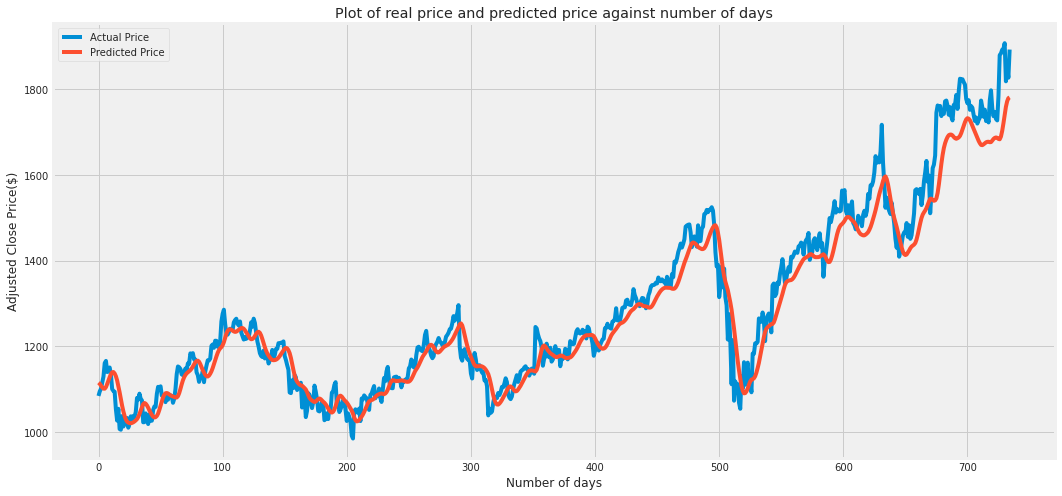

In [35]:
# plotting the real and predicted prices of the LSTM_seq model
pred_plot(y_test, y_pred_1)

In [36]:
# calculating the model metrics

def model_metrics(y_test, y_pred):
  MSE = (mean_squared_error(y_test, y_pred))
  RMSE = (np.sqrt(mean_squared_error(y_test, y_pred)))
  print("MSE: %.2f" %(MSE))
  print("RMSE: %.2f" %(RMSE))

In [37]:
# evaluating the performance of the LSTM_seq model on the test set
model_metrics(y_test, y_pred_1)

MSE: 2526.10
RMSE: 50.26


In [48]:
y_train_norm = y_reverse_normaliser.inverse_transform(y_train)
model_metrics(y_train_norm, y_train_pred_1)

MSE: 256.93
RMSE: 16.03


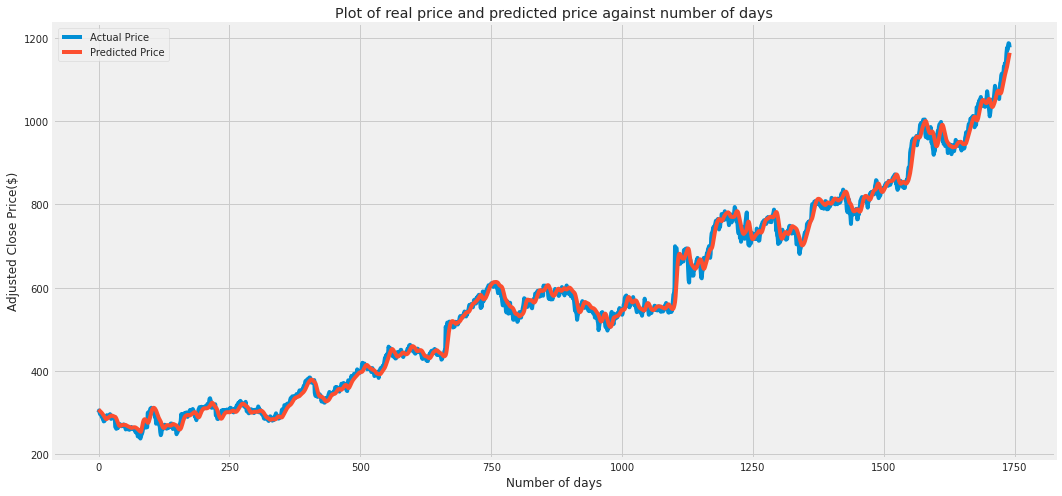

In [49]:
pred_plot(y_train_norm, y_train_pred_1)

**INFERENCE:** From the models evaluated metrics, we can see that model performed well on the training set but poorly on the test set and this is an indication of overfitting.

This is most likely due to the dataset being too small for the depth of the LSTM architecture.

### ALTERATION ONE - Utilizing a smaller LSTM architecture

Here the LSTM architecture will defined as a functional api with only one LSTM layer and two dense layers. 

In [38]:
def lstm_model_fnc(X_train, y_train, history_points, n_columns):
    tf.random.set_seed(20)
    np.random.seed(10)
    lstm_input = Input(shape=(history_points, n_columns), name='lstm_input')

    inputs = LSTM(21, name='lstm_layer')(lstm_input)
    inputs = Dropout(0.1, name='dropout_layer')(inputs)
    inputs = Dense(16, name='first_dense_layer')(inputs)
    inputs = Dense(1, name='dense_layer')(inputs)
    output = Activation('linear', name='output')(inputs)

    model = Model(inputs=lstm_input, outputs=output)

    model.compile(optimizer= 'adam', loss='mse')
    model.summary()

     # initialize callbacks
    reduceLR = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-5)

    # induces early stopping if there is no change in validation loss after 20 epochs
    early_stopping = EarlyStopping(monitor='val_loss', patience = 20, verbose=1, mode='min', restore_best_weights= True)

    # saves the model weights after each epoch in which there is an improvement in validation loss
    checkpoint = ModelCheckpoint('LSTM_fncModel.weights.hdf5', monitor='val_loss', verbose=1,save_best_only=True, mode= 'min')

    # training the RNN
    model.fit(x= X_train, y= y_train, epochs = 150, batch_size = 32, shuffle=True, validation_split = 0.1, 
              callbacks= [reduceLR, early_stopping, checkpoint])

    # loading best weights into model
    model.load_weights('LSTM_fncModel.weights.hdf5')

    
    return model
    

In [39]:
#training the model 
n_columns = 2
model_2 = lstm_model_fnc(X_train, y_train, history_points, n_columns)
model_2.save('{}LSTM_fncModel.h5'.format(save_files_dir))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 21, 2)]           0         
                                                                 
 lstm_layer (LSTM)           (None, 21)                2016      
                                                                 
 dropout_layer (Dropout)     (None, 21)                0         
                                                                 
 first_dense_layer (Dense)   (None, 16)                352       
                                                                 
 dense_layer (Dense)         (None, 1)                 17        
                                                                 
 output (Activation)         (None, 1)                 0         
                                                                 
Total params: 2,385
Trainable params: 2,385
Non-trainable par

In [40]:
# making predictions using the trained model
y_pred_2 = model_pred(model_2, X_test)
y_train_pred_2 = model_pred(model_2, X_train)

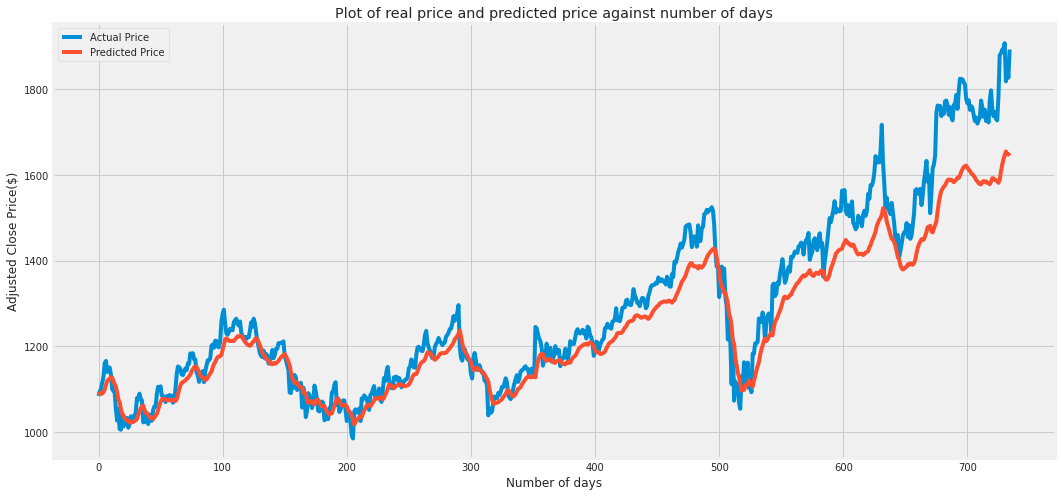

In [41]:
# plotting the real and predicted prices
pred_plot(y_test, y_pred_2)

In [42]:
model_metrics(y_test, y_pred_2)

MSE: 5755.71
RMSE: 75.87


In [50]:
model_metrics(y_train_norm, y_train_pred_2)

MSE: 181.29
RMSE: 13.46


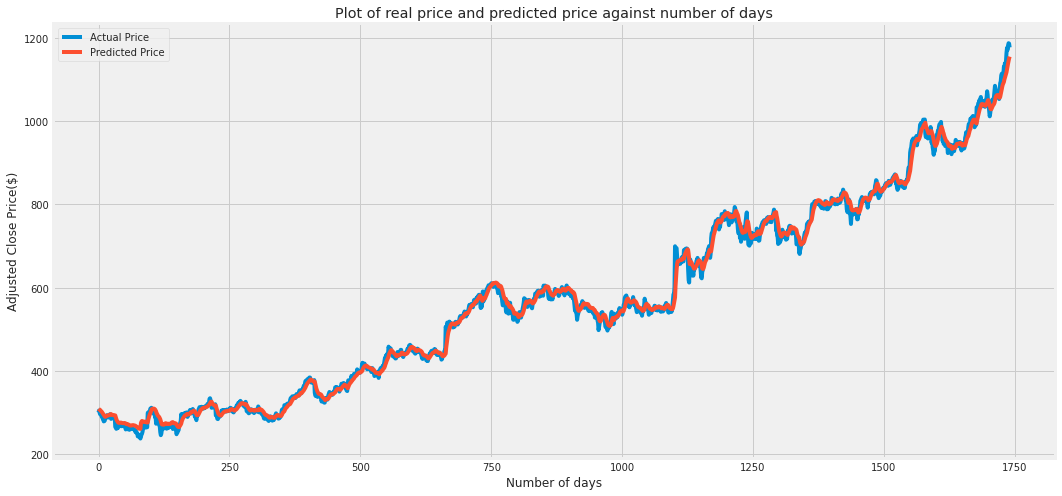

In [51]:
pred_plot(y_train_norm, y_train_pred_2)

The RMSE value of the model for the training set reduced while that of the test set increased indicating that the model is still overfitting to the training data and has poor generalization. 

### ALTERATION TWO - Balancing the LSTM architecture

Here we will strike a balance between both models by using two LSTM layers, two dense layers, and the initial learning rate will be specified.

In [75]:
# This function defines the LSTM architecture as a functional api and the developed model will be used for training.

def lstm_model_fnc_2(X_train, y_train, history_points, n_columns):
    #Setting of seed (to maintain constant result)
    tf.random.set_seed(20)
    np.random.seed(10)

    lstm_input = Input(shape=(history_points, n_columns), name='input_for_lstm')

    inputs = LSTM(21, name='first_layer', return_sequences = True)(lstm_input)

    inputs = Dropout(0.1, name='first_dropout_layer')(inputs)
    inputs = LSTM(32, name='lstm_1')(inputs)
    inputs = Dropout(0.05, name='lstm_dropout_1')(inputs) #Dropout layers to prevent overfitting
    inputs = Dense(32, name='first_dense_layer')(inputs)
    inputs = Dense(1, name='dense_layer')(inputs)
    output = Activation('linear', name='output')(inputs)

    model = Model(inputs=lstm_input, outputs=output)
    adam = tf.keras.optimizers.Adam(learning_rate = 0.002)

    model.compile(optimizer=adam, loss='mse')
    model.summary()

    # initialize callbacks
    reduceLR = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-5)

    # induces early stopping if there is no change in validation loss after 20 epochs
    early_stopping = EarlyStopping(monitor='val_loss', patience = 20, verbose=1, mode='min', restore_best_weights= True)

    # saves the model weights after each epoch in which there is an improvement in validation loss
    checkpoint = ModelCheckpoint('LSTM_fnc_2Model.weights.hdf5', monitor='val_loss', verbose=1,save_best_only=True, mode= 'min')

    # training the RNN
    model.fit(x= X_train, y= y_train, epochs = 300, batch_size = 32, shuffle=True, validation_split = 0.1, 
              callbacks= [reduceLR, early_stopping, checkpoint])

    # loading best weights into model
    model.load_weights('LSTM_fnc_2Model.weights.hdf5')

    
    return model

In [53]:
#training the model 
model_3 = lstm_model_fnc_2(X_train, y_train, history_points, n_columns)
model_3.save('{}LSTM_fnc_2Model.h5'.format(save_files_dir))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_for_lstm (InputLayer)  [(None, 21, 2)]          0         
                                                                 
 first_layer (LSTM)          (None, 21, 21)            2016      
                                                                 
 first_dropout_layer (Dropou  (None, 21, 21)           0         
 t)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 32)                6912      
                                                                 
 lstm_dropout_1 (Dropout)    (None, 32)                0         
                                                                 
 first_dense_layer (Dense)   (None, 32)                1056      
                                                           

In [54]:
# making predictions using the trained model
y_pred_3 = model_pred(model_3, X_test)

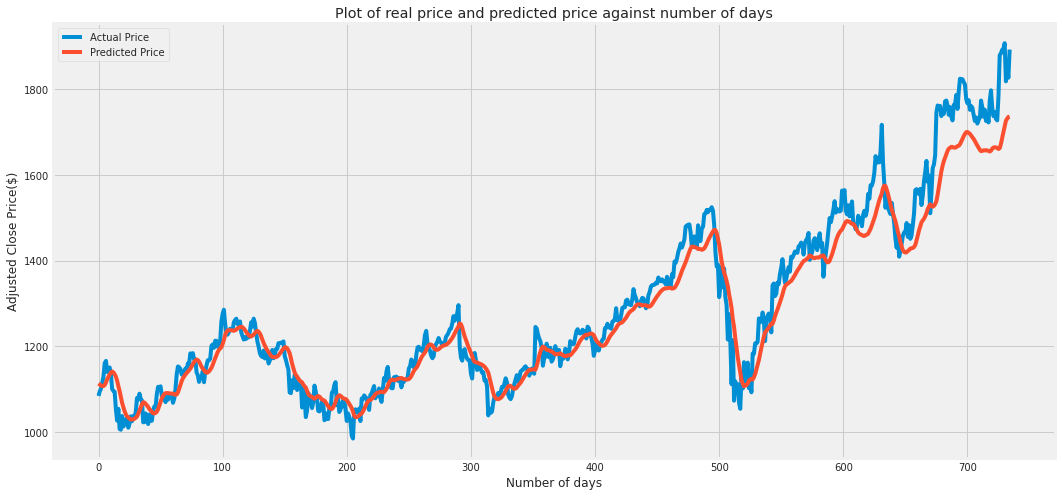

In [55]:
# plotting the real and predicted prices
pred_plot(y_test, y_pred_3)

In [56]:
model_metrics(y_test, y_pred_3)

MSE: 2893.06
RMSE: 53.79


In [57]:
y_train_pred_3 = model_pred(model_3, X_train)
model_metrics(y_train_norm, y_train_pred_3)

MSE: 264.35
RMSE: 16.26


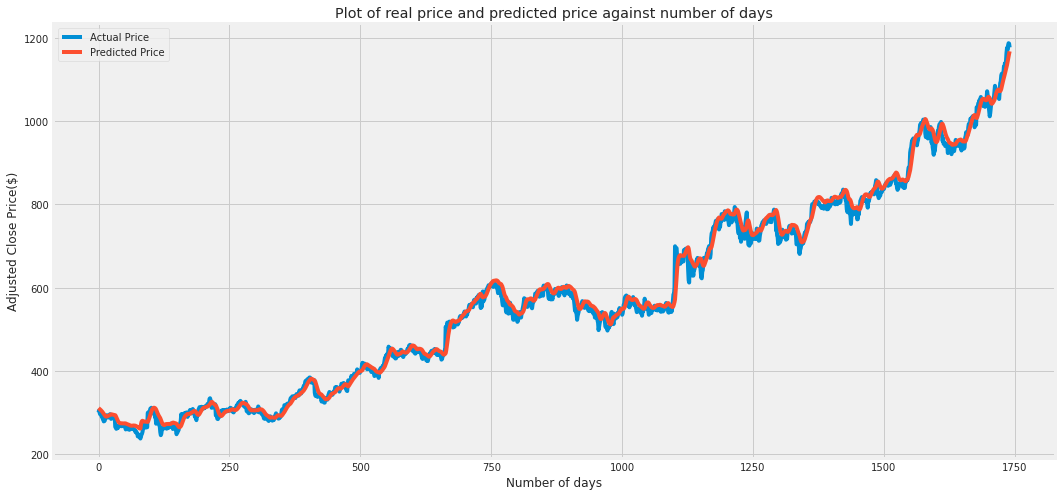

In [58]:
pred_plot(y_train_norm, y_train_pred_3)

Regardless of the alteration in the model architecture, the model is still overfitting to the training data hence, we will alter the dataset by adding technical indicators and then training each model with it and evaluating its performance.

### ALTERATION THREE - Feature Engineering

Here we will be adding two technical indicators as features in the dataset. 

The first indicator is the exponential moving average(EMA) which is a weighted version of the moving average as it gives more weight to recent price data.

The second indicator is Bollinger Bands(BB) which computes the overbought and oversold conditions of a stock thus, it is used in trading to identify entry and exit points consequently influencing the stock price movement.

This will provide the network with more data to train with while also improving its learning. 

#### Data Preprocessing

In [59]:
# creating a new dataframe 
new_df_2 = on_balance_volume_creation(stock_df)
new_df_2.head()

,Adj Close,On_Balance_Volume
0,300.480469,18.337813
1,305.825836,18.395695
2,306.306305,18.431129
3,305.380371,18.401121
4,305.795807,18.432229


In [61]:
# this function concatenates the values of two technical indicators to the data

def add_technical_indicators(new_df):
    # Adding of technical indicators to data frame (Exponential moving average and Bollinger Band)
    edited_df = pd.DataFrame()

    edited_df['open'] = stock_df['Open']
    edited_df['high'] = stock_df['High']
    edited_df['low'] = stock_df['Low']
    edited_df['close'] = stock_df['Close']
    edited_df['volume'] = stock_df['Volume']
    edited_df.head()

    ema = TA.EMA(edited_df)
    bb = TA.BBANDS(edited_df)

    new_df['Exponential_moving_average'] = ema.copy()

    new_df = pd.concat([new_df, bb], axis = 1)


    for i in range(19):
        new_df['BB_MIDDLE'][i] = new_df.loc[i, 'Exponential_moving_average']
    
        if i != 0:
            higher = new_df.loc[i, 'BB_MIDDLE'] + 2 * new_df['Adj Close'].rolling(i + 1).std()[i]
            lower = new_df.loc[i, 'BB_MIDDLE'] - 2 * new_df['Adj Close'].rolling(i + 1).std()[i]
            new_df['BB_UPPER'][i] = higher
            new_df['BB_LOWER'][i] = lower
        else:
            new_df['BB_UPPER'][i] = new_df.loc[i, 'BB_MIDDLE']
            new_df['BB_LOWER'][i] = new_df.loc[i, 'BB_MIDDLE']
    return new_df

In [62]:
# adding the technical indicators to the data
new_df_2 = add_technical_indicators(new_df_2)
new_df_2.head()

,Adj Close,On_Balance_Volume,Exponential_moving_average,BB_UPPER,BB_MIDDLE,BB_LOWER
0,300.480469,18.337813,300.480469,300.480469,300.480469,300.480469
1,305.825836,18.395695,303.450117,311.009608,303.450117,295.890626
2,306.306305,18.431129,304.620686,311.088255,304.620686,298.153117
3,305.380371,18.401121,304.878032,310.288177,304.878032,299.467887
4,305.795807,18.432229,305.151049,309.977972,305.151049,300.324126


In [63]:
# normalizing and splitting the new data
train_split = 0.7
    
history_points = 21

X2_train, y2_train, X2_test, y2_test, y_reverse_normaliser = train_test_split_preparation(new_df_2, train_split)
np.shape(X2_train), np.shape(y2_train)

((1741, 21, 6), (1741, 1))

#### LSTM_SEQ Model Training

In [64]:
# training the LSTM_seq model with the new data
n_columns = 6
model_1b = lstm_model_seq(X2_train, y2_train, history_points, n_columns)
# saving the model into the specified google drive directory
model_1b.save('{}LSTM_seqModel_newdata.h5'.format(save_files_dir))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 21, 256)           269312    
                                                                 
 dropout_3 (Dropout)         (None, 21, 256)           0         
                                                                 
 lstm_4 (LSTM)               (None, 21, 128)           197120    
                                                                 
 dropout_4 (Dropout)         (None, 21, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 21)               

In [65]:
# making predictions using the LSTM_seq trained model
y2_pred_1 = model_pred(model_1b, X2_test)
y2_train_pred_1 = model_pred(model_1b, X2_train)

In [66]:
# unscaling the actual data 
y2_train_norm = y_reverse_normaliser.inverse_transform(y2_train)

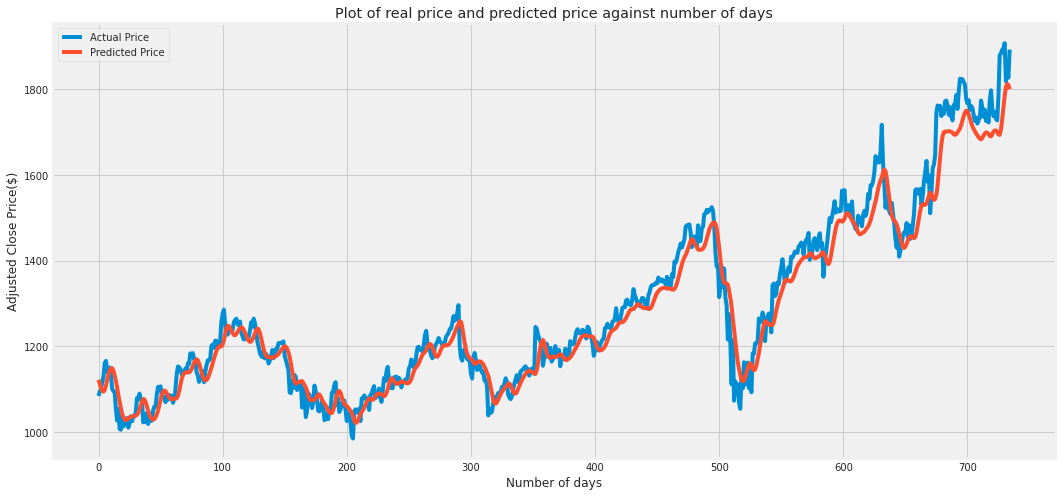

In [67]:
# plotting the real and predicted prices
pred_plot(y2_test, y2_pred_1)

In [68]:
# evaluating the performance of the LSTM_seq model on the new test data
model_metrics(y2_test, y2_pred_1)

MSE: 1953.10
RMSE: 44.19


In [69]:
# evaluating the performance of the LSTM_seq model on the new train data
model_metrics(y2_train_norm, y2_train_pred_1)

MSE: 211.25
RMSE: 14.53


#### LSTM_FNC Model Training(New dataset)

In [70]:
# training the LSTM_fnc model with the new data
model_2b = lstm_model_fnc(X2_train, y2_train, history_points, n_columns)
# saving the model into the specified google drive directory
model_2b.save('{}LSTM_fncModel_newdata.h5'.format(save_files_dir))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 21, 6)]           0         
                                                                 
 lstm_layer (LSTM)           (None, 21)                2352      
                                                                 
 dropout_layer (Dropout)     (None, 21)                0         
                                                                 
 first_dense_layer (Dense)   (None, 16)                352       
                                                                 
 dense_layer (Dense)         (None, 1)                 17        
                                                                 
 output (Activation)         (None, 1)                 0         
                                                                 
Total params: 2,721
Trainable params: 2,721
Non-trainable p

In [71]:
# making predictions using the LSTM_seq trained model
y2_pred_2 = model_pred(model_2b, X2_test)
y2_train_pred_2 = model_pred(model_2b, X2_train)

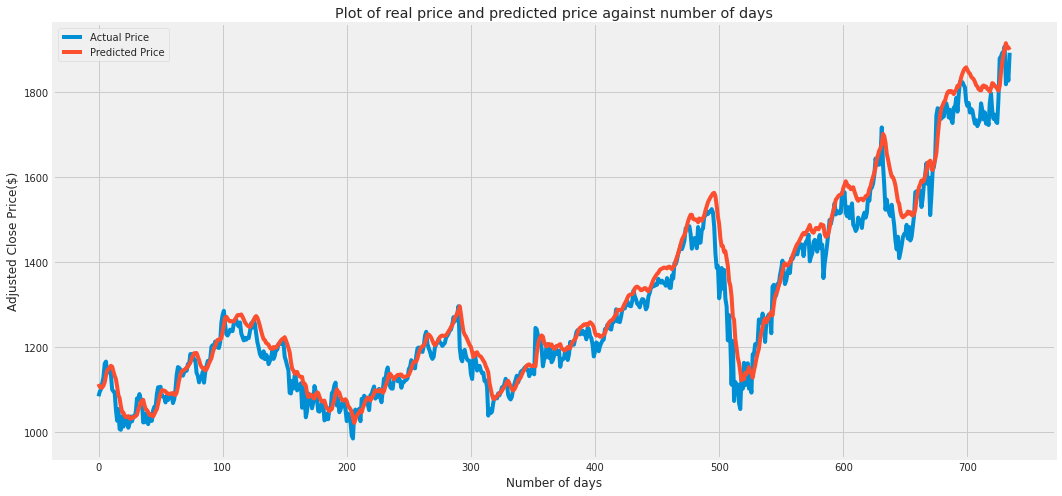

In [72]:
# plotting the real and predicted prices
pred_plot(y2_test, y2_pred_2)

In [73]:
# evaluating the performance of the LSTM_fnc model on the test set
model_metrics(y2_test, y2_pred_2)

MSE: 1889.06
RMSE: 43.46


In [74]:
# evaluating the performance of the LSTM_fnc model on the new train data
model_metrics(y2_train_norm, y2_train_pred_1)

MSE: 211.25
RMSE: 14.53


#### LSTM_FNC_2 Model Training(New Dataset)

In [76]:
# training the LSTM_fnc_2 model with the new data
n_columns = 6
model_3b = lstm_model_fnc_2(X2_train, y2_train, history_points, n_columns)
# saving the model into the specified google drive directory
model_3b.save('{}LSTM_fnc_2Model_newdata.h5'.format(save_files_dir))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_for_lstm (InputLayer)  [(None, 21, 6)]          0         
                                                                 
 first_layer (LSTM)          (None, 21, 21)            2352      
                                                                 
 first_dropout_layer (Dropou  (None, 21, 21)           0         
 t)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 32)                6912      
                                                                 
 lstm_dropout_1 (Dropout)    (None, 32)                0         
                                                                 
 first_dense_layer (Dense)   (None, 32)                1056      
                                                           

In [77]:
# making predictions using the LSTM_fnc_2 trained model on the new test data
y2_pred_3 = model_pred(model_3b, X2_test)
y2_train_pred_3 = model_pred(model_3b, X2_train)

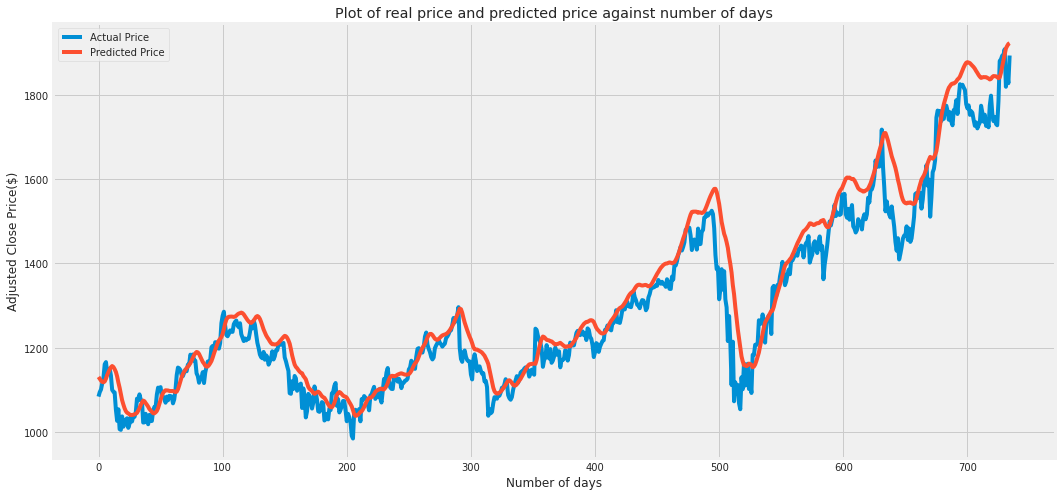

In [78]:
# plotting the real and predicted prices
pred_plot(y2_test, y2_pred_3)

In [79]:
# evaluating the performance of the LSTM_fnc_2 model on the new test data
model_metrics(y2_test, y2_pred_3)

MSE: 3438.75
RMSE: 58.64


In [80]:
# evaluating the performance of the LSTM_fnc_2 model on the new train data
model_metrics(y2_train_norm, y2_train_pred_3)

MSE: 229.48
RMSE: 15.15


### ALTERATION FOUR - Normalization using Standard Scaler

Here we will use standard scaling to scale the new dataset with technical indicators as features. 

Minmax scaling scales the features with the largest value in the dataset assumed to be the highest value possible. This means that the model cannot predict a price higher than the maximum value in the training data. 

Standard scaler on the other hand uses the mean and standard devaiation of the data to perform normalization thus making the model more likely to predict trends better.

In [81]:
# This function performs data normalization and train_test_split

def train_test_split_preparation(new_df, train_split):
    #Preparation of train test set.
    train_indices = int(new_df.shape[0] * train_split) # multiplies the total number of rows (2517) by 70% and this will be used as training data

    train_data = new_df[:train_indices]   
    test_data = new_df[train_indices:]

    test_data = test_data.reset_index()
    test_data = test_data.drop(columns = ['index'])

    normaliser = preprocessing.StandardScaler()
    train_normalised_data = normaliser.fit_transform(train_data)

    test_normalised_data = normaliser.transform(test_data)

    X_train = np.array([train_normalised_data[:,0:][i : i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])

    y_train = np.array([train_normalised_data[:,0][i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])
    y_train = np.expand_dims(y_train, -1)

    y_normaliser = preprocessing.StandardScaler()
    next_day_close_values = np.array([train_data['Adj Close'][i + history_points].copy() for i in range(len(train_data) - history_points)])
    next_day_close_values = np.expand_dims(next_day_close_values, -1)

    y_normaliser.fit(next_day_close_values)

     
    X_test = np.array([test_normalised_data[:,0:][i  : i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])
    

    y_test = np.array([test_data['Adj Close'][i + history_points].copy() for i in range(len(test_data) - history_points)])
    
    y_test = np.expand_dims(y_test, -1)

    return X_train, y_train, X_test, y_test, y_normaliser

In [82]:
# normalizing and splitting the new data
train_split = 0.7
    
history_points = 21

X3_train, y3_train, X3_test, y3_test, y_reverse_normaliser = train_test_split_preparation(new_df_2, train_split)
np.shape(X3_train), np.shape(y3_train)

((1741, 21, 6), (1741, 1))

#### Using the LSTM_SEQ Model for Final Training

In [83]:
# training the LSTM_seq model with the new data
n_columns = 6
final_model = lstm_model_seq(X3_train, y3_train, history_points, n_columns)
# saving the model into the specified google drive directory
final_model.save('{}LSTM_seqModel_final.h5'.format(save_files_dir))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 21, 256)           269312    
                                                                 
 dropout_6 (Dropout)         (None, 21, 256)           0         
                                                                 
 lstm_7 (LSTM)               (None, 21, 128)           197120    
                                                                 
 dropout_7 (Dropout)         (None, 21, 128)           0         
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 21)               

In [84]:
# making predictions using the LSTM_seq trained model
y3_pred_1 = model_pred(final_model, X3_test)
y3_train_pred_1 = model_pred(final_model, X3_train)

In [85]:
# unscaling the actual data 
y3_train_norm = y_reverse_normaliser.inverse_transform(y3_train)

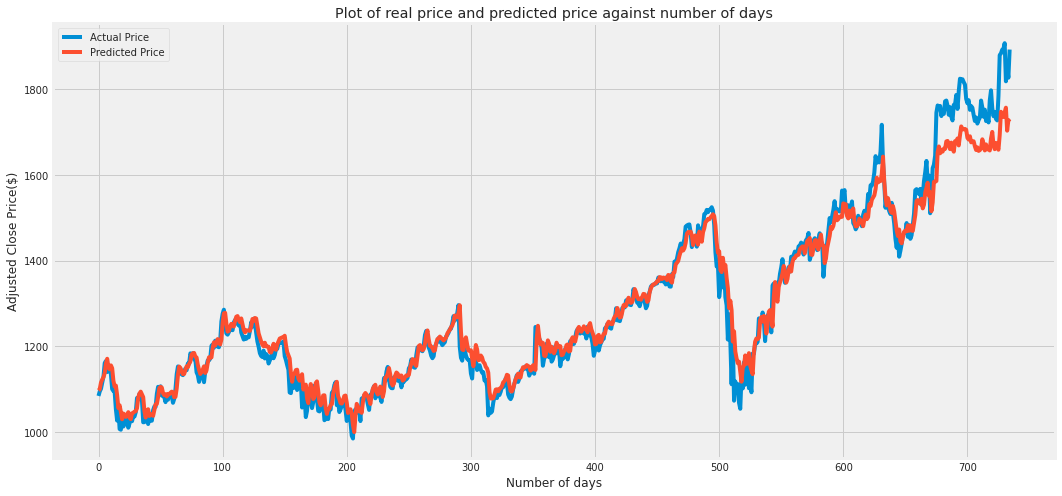

In [86]:
# plotting the real and predicted prices for the test data
pred_plot(y3_test, y3_pred_1)

In [87]:
# evaluating the performance of the LSTM_seq model on the new test data
model_metrics(y3_test, y3_pred_1)

MSE: 1602.29
RMSE: 40.03


In [88]:
# evaluating the performance of the LSTM_seq model on the new train data
model_metrics(y3_train_norm, y3_train_pred_1)

MSE: 88.36
RMSE: 9.40
